### Імпорт залежностей

Спочатку імпортуємо необхідні бібліотеки

In [16]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Нейронна мережа DQN

Визначаємо повнозв’язну нейронну мережу з трьома шарами:

- Вхід: 4 числа — поточний стан середовища CartPole-v1  
  → позиція візка, швидкість візка, кут палиці, кутова швидкість
- 2 прихованих шари по 128 нейронів з активацією ReLU
- Вихід: 2 числа — оцінки (Q-values) для кожної дії  
  → [0] посунути візок наліво
  → [1] посунути візок направо

Мережа намагається передбачити, яка з двох дій принесе найбільшу сумарну нагороду в майбутньому.

In [17]:
class DQN(nn.Module):
    def __init__(self, state_size=4, action_size=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )
    
    def forward(self, x):
        return self.net(x)

### Буфер повторного досвіду (Replay Buffer)

Це один з найважливіших компонентів DQN - «пам’ять» агента.

Без нього агент би вчився тільки на останніх кількох кроках і швидко все забував.  
З буфером ми зберігаємо тисячі минулих переходів і навчаємо мережу на випадкових порціях (міні-батчах) з них.

In [18]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state),
                np.array(action),
                np.array(reward, dtype=np.float32),
                np.array(next_state),
                np.array(done, dtype=np.float32))
    
    def __len__(self):
        return len(self.buffer)

### DQN Agent

Клас DQNAgent реалізує поведінку агента, який навчається за алгоритмом Deep Q-Network (DQN). Він відповідає за вибір дій, накопичення досвіду, оновлення параметрів нейронної мережі та керування процесом дослідження (exploration).

У конструкторі задаються основні параметри навчання:
gamma = 0.99 — коефіцієнт дисконтування, який визначає важливість майбутніх винагород.
epsilon, epsilon_min, epsilon_decay — параметри ε-greedy політики, що контролюють баланс між дослідженням та використанням знань.
batch_size = 64 — розмір вибірки при оновленні мережі.
target_update = 10 — частота оновлення параметрів target-мережі.

Агент використовує дві нейронні мережі:
policy_net - основна мережа, яка навчається і генерує Q-величини.
target_net - цільова мережа, що слугує стабільним орієнтиром для обчислення цільових значень. Її параметри періодично копіюються з policy_net.
Для оптимізації використовується Adam з кроком навчання 0.001.
Клас також містить буфер досвіду ReplayBuffer, куди зберігаються всі переходи (s, a, r, s′, done).

In [19]:
class DQNAgent:
    def __init__(self, state_size=4, action_size=2):
        self.state_size = state_size
        self.action_size = action_size
        
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.target_update = 10
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayBuffer()
        self.steps = 0
    
    def act(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            return self.policy_net(state).argmax(1).item()
    
    def remember(self, s, a, r, ns, done):
        self.memory.push(s, a, r, ns, done)
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        current_q = self.policy_net(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

### Навчання

Функція train() відповідає за повний процес навчання агента у середовищі CartPole-v1. Вона виконує ініціалізацію середовища, організовує цикл епізодів, керує взаємодією агента з середовищем, накопиченням досвіду, процесом навчання та збереженням результатів.

In [29]:
def train(episodes=800):
    env = gym.make("CartPole-v1")
    agent = DQNAgent()
    
    scores = []
    avg_scores = []
    scores_window = deque(maxlen=100)
    
    print("Training started...\n")
    
    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        score = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if done and score < 499:
                reward = -10
                
            agent.remember(state, action, reward, next_state, done)
            agent.learn()
            
            state = next_state
            score += 1
            
            if done:
                break
        
        agent.decay_epsilon()
        
        scores.append(score)
        scores_window.append(score)
        avg = np.mean(scores_window)
        avg_scores.append(avg)
        
        if episode % 20 == 0:
            print(f"Episode {episode:3d} | Score: {score:3d} | Avg: {avg:5.1f} | ε: {agent.epsilon:.3f}")
        
        if avg >= 195.0 and episode >= 100:
            print(f"\nSOLVED in {episode} episodes! Avg score: {avg:.1f}")
            break
    
    env.close()
    
    # Save model
    torch.save(agent.policy_net.state_dict(), "dqn_cartpole.pth")
    print("\nModel saved as 'dqn_cartpole.pth'")
    
    return agent, scores, avg_scores

# Start training
agent, scores, avg_scores = train(episodes=800)

Training started...

Episode  20 | Score:  23 | Avg:  20.7 | ε: 0.905
Episode  40 | Score:  53 | Avg:  25.7 | ε: 0.818
Episode  60 | Score:  31 | Avg:  30.6 | ε: 0.740
Episode  80 | Score:  94 | Avg:  39.0 | ε: 0.670
Episode 100 | Score:  20 | Avg:  43.7 | ε: 0.606
Episode 120 | Score:  48 | Avg:  63.0 | ε: 0.548
Episode 140 | Score: 131 | Avg:  77.2 | ε: 0.496
Episode 160 | Score: 145 | Avg:  91.0 | ε: 0.448
Episode 180 | Score: 158 | Avg:  91.3 | ε: 0.406
Episode 200 | Score:  47 | Avg:  94.8 | ε: 0.367
Episode 220 | Score: 118 | Avg: 100.4 | ε: 0.332
Episode 240 | Score: 111 | Avg:  98.3 | ε: 0.300
Episode 260 | Score: 250 | Avg: 110.6 | ε: 0.272
Episode 280 | Score: 104 | Avg: 121.4 | ε: 0.246
Episode 300 | Score: 140 | Avg: 125.7 | ε: 0.222
Episode 320 | Score: 177 | Avg: 135.5 | ε: 0.201
Episode 340 | Score: 500 | Avg: 160.9 | ε: 0.182
Episode 360 | Score: 500 | Avg: 189.9 | ε: 0.165

SOLVED in 373 episodes! Avg score: 195.2

Model saved as 'dqn_cartpole.pth'


### Візуалізація результатів навчання

Графіки, що показують увесь прогрес агента.

На першому графіку зображено два ключових показники:
scores - значення сумарної винагороди в кожному епізоді (синя крива з прозорістю). Вони демонструють, як агент поводиться на кожному кроці навчання та як з часом зменшується кількість випадковості у його діях.
avg_scores - ковзне середнє за 100 епізодів (червона крива). Це основний індикатор стабільного прогресу.
Зелена пунктирна лінія на рівні 195 відповідає критерію розв’язання середовища CartPole-v1. Перетин цієї межі ковзним середнім означає, що агент демонструє стабільно високу якість.

Другий графік окремо фокусується лише на ковзному середньому значенні. Це дозволяє краще оцінювати стабільність, без шуму, який створюють одиничні епізоди.
Помаранчева лінія показує, як змінюється середній результат у процесі навчання.
Зелена лінія 195 знову виступає порогом успішності.

Третій графік ілюструє процес зменшення ε - параметра, що відповідає за імовірність випадкової дії (exploration).

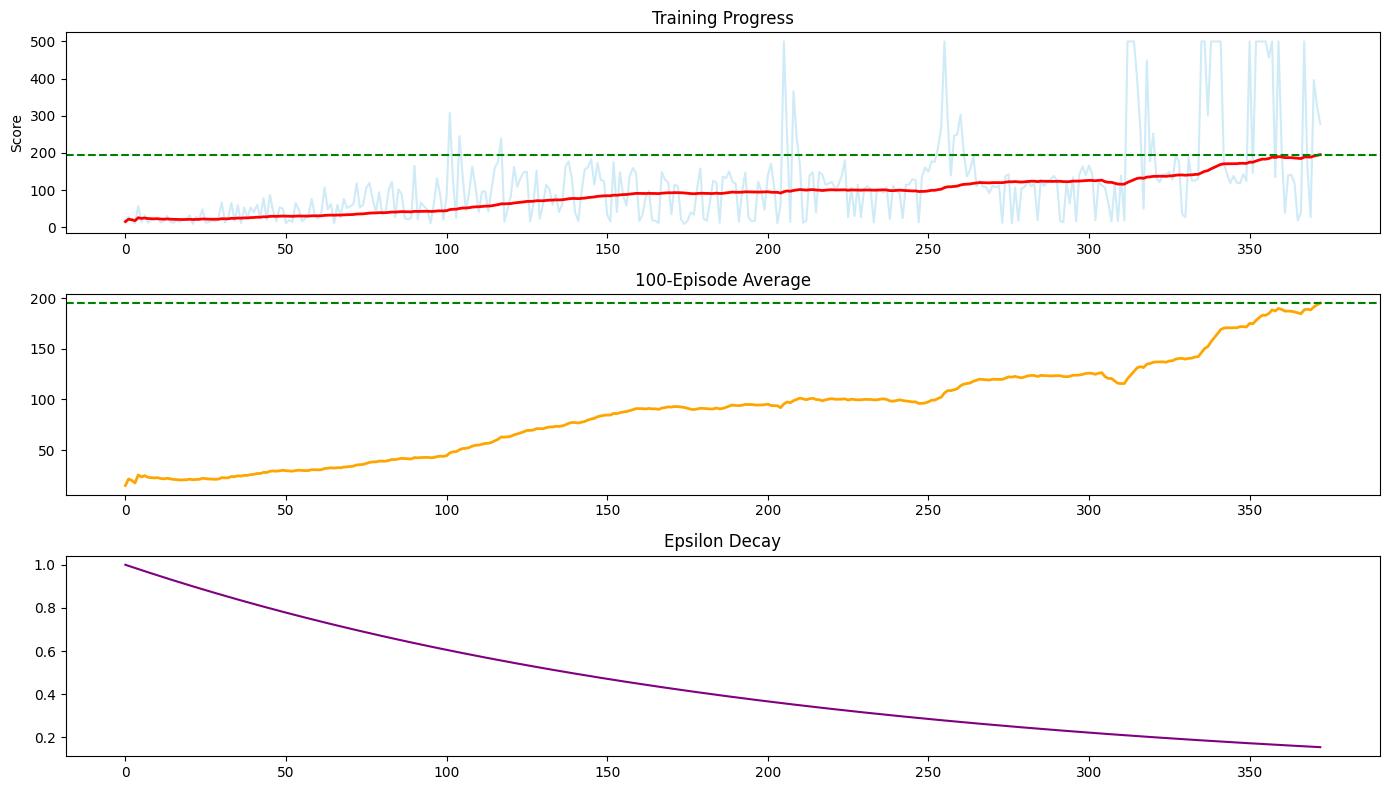

In [30]:
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(scores, alpha=0.4, color='skyblue')
plt.plot(avg_scores, color='red', linewidth=2)
plt.axhline(195, color='green', linestyle='--')
plt.title("Training Progress")
plt.ylabel("Score")

plt.subplot(3, 1, 2)
plt.plot(avg_scores, color='orange', linewidth=2)
plt.axhline(195, color='green', linestyle='--')
plt.title("100-Episode Average")

plt.subplot(3, 1, 3)
eps = [max(0.01, 1.0 * (0.995 ** i)) for i in range(len(avg_scores))]
plt.plot(eps, color='purple')
plt.title("Epsilon Decay")

plt.tight_layout()
plt.show()

### Демонстрація навченого агента

In [32]:
env = gym.make("CartPole-v1", render_mode="human")

for i in range(3):
    state, _ = env.reset()
    score = 0
    done = False
    
    while not done:
        env.render()
        action = agent.act(state, training=False)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        score += 1
    
    print(f"Test {i+1}/3 → Score: {score}")

env.close()

Test 1/3 → Score: 500
Test 2/3 → Score: 500
Test 3/3 → Score: 500
